# Multi-task logistic regression for individual survival prediction
Multi-task logistic regression (MTLR) is a machine learning model for survival prediction. It overcomes many of the limitations of existing methods (e.g. the Cox proportional hazard model) by directly modelling the survival curve of each individual, allowing for more accurate individualised survival prediction. This notebook contains a PyTorch implementation of MTLR, together with experiments on simulated and real data. In the blog post (coming soon!), I will give the derivation and theoretical background for the model.

In [1]:
%matplotlib inline 
from math import sqrt, ceil
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from scipy.interpolate import interp1d
from tqdm import tqdm, trange

from torchmtlr import MTLR, mtlr_neg_log_likelihood, mtlr_cif, mtlr_risk, mtlr_survival
from torchmtlr.utils import make_time_bins, encode_survival, reset_parameters

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

device = "cpu"

sns.set(context="poster", style="white")
plt.rcParams["figure.figsize"] = (10, 7)

## MTLR implementation
Quick remark on notation: subscripts (e.g. $x_k$) denote indexing over timepoints, while superscripts (like $y^{(j)}$) indicate indexing over datapoints.

First comes the MTLR likelihood implementation. You can find the original likelihood definition in [the original publication](https://papers.nips.cc/paper/4210-learning-patient-specific-cancer-survival-distributions-as-a-sequence-of-dependent-regressors). Briefly, the approach is to discretise the time axis into $K$ bins and fit a logistic regression model to predict the probability of event in each bin.

<center><img src="time_bins.png" width="600"> </center>

*[Image source](https://era.library.ualberta.ca/items/3deb4dd9-788d-4c61-94a5-d3ee6645f74f).*


The probability of event time $T$ falling in the bin $[\tau_{i-1}, \tau_i)$ given covariates $\mathbf{x}$ is modelled as:

$$
P(\tau_{i-1} \le T < \tau_i | \mathbf{x}, \boldsymbol{\theta}) = \frac{\exp(\sum_{k=i}^{K-1}\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k)}{Z(\mathbf{x}, \boldsymbol{\Theta})},
$$

where $\boldsymbol{\theta}_k, b_k$ are the model parameters and $Z = \sum_{i=1}^K \exp(\sum_{k=i}^{K-1}\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k)$ is the normalizing constant.

Here, we use the reformulation as softmax classifier (first derived [here](https://era.library.ualberta.ca/items/3deb4dd9-788d-4c61-94a5-d3ee6645f74f)), allowing for more efficient computation. Each uncensored instance is now assigned a single *class label*, which is represented as one-hot encoded binary vector. For instances censored at time $t_c$, we know that their true class label lies between $c_c$ and $c_K$, which is encoded as a binary vector with 1s at all indices $c-1 \le i \le K-1$. In this case, the 1s indicate the timepoints over which to marginalise. For example, if the time axis is split into 5 bins, an instance experiencing event in bin 3 (0-indexed) is encoded as `[0, 0, 0, 1, 0]`, and instance censored in bin 2 as `[0, 0, 1, 1, 1]`.

The log-likelihood for uncensored instances is similar to the standard softmax log-likelihood:

$$
L(\boldsymbol{\Theta}, \mathbf{x}, \mathbf{y}) = \sum_{k=i}^{K-1}(\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k) - \log(Z(\mathbf{x}, \boldsymbol{\Theta})),
$$

where $i$ is the index of non-zero entry in $\mathbf{y}$.

For censored instances, we need to sum (marginalize) over all possible class probabilities:

$$
L(\boldsymbol{\Theta}, \mathbf{x}, \mathbf{y}) = \log(\sum_i \exp(\sum_{k=i}^{K-1}\mathbf{x} \cdot \boldsymbol{\theta}_k + b_k) - \log(Z(\mathbf{x}, \boldsymbol{\Theta})),
$$

where the sum is over all non-zero entries in $\mathbf{y}$.

Here, the summation is over all timepoints later than the censoring time $T_c$.

The full log-likelihood for a dataset $D = {(\mathbf{x}^{(j)}, y^{(j)})}_{j=1}^{N}$ with $N$ instances, $N_c$ of which are censored, is 

$$
L(\boldsymbol{\Theta}, D) =
\sum_{j=1}^{N-N_c}\sum_{k=1}^{K-1}(\mathbf{x}^{(j)} \cdot \boldsymbol{\theta}_k + b_k)\mathbf{y}_k^{(j)} + 
\sum_{j=N_c}^{N}\log(\sum_{t_k > T_c^{(j)}} \exp(\sum_{k=1}^{K-1}\mathbf{x}^{(j)} \cdot \boldsymbol{\theta}_k + b_k)
- \sum_{j=1}^{N}\log(Z(\mathbf{x}^{(j)}, \boldsymbol{\Theta})) + \frac{C_1}{2}\sum_{k=1}^{K-1}\Vert\boldsymbol{\theta}_k\Vert^2.
$$

$C_1$ is a hyperparameter determining the strength of $L_2$ regularisation, which also controls the smoothness of predicted survival curves.

Next come a few utility functions.

In [2]:
def make_optimizer(opt_cls, model, **kwargs):
    """Creates a PyTorch optimizer for MTLR training."""
    params_dict = dict(model.named_parameters())
    weights = [v for k, v in params_dict.items() if "mtlr" not in k and "bias" not in k]
    biases = [v for k, v in params_dict.items() if "bias" in k]
    mtlr_weights = [v for k, v in params_dict.items() if "mtlr_weight" in k]
    # Don't use weight decay on the biases and MTLR parameters, which have
    # their own separate L2 regularization
    optimizer = opt_cls([
        {"params": weights},
        {"params": biases, "weight_decay": 0.},
        {"params": mtlr_weights, "weight_decay": 0.},
    ], **kwargs)
    return optimizer

In [3]:
def normalize(data, mean=None, std=None, skip_cols=[]):
    """Normalizes the columns of Pandas DataFrame to zero mean and unit
    standard deviation."""
    if mean is None:
        mean = data.mean(axis=0)
    if std is None:
        std = data.std(axis=0)
    if skip_cols is not None:
        mean[skip_cols] = 0
        std[skip_cols] = 1
    return (data - mean) / std, mean, std


# training functions
def train_mtlr(model, data_train, time_bins,
               num_epochs=1000, lr=.01, weight_decay=0.,
               C1=1., batch_size=None,
               verbose=True, device="cpu"):
    """Trains the MTLR model using minibatch gradient descent.
    
    Parameters
    ----------
    model : torch.nn.Module
        MTLR model to train.
    data_train : pd.DataFrame
        The training dataset. Must contain a `time` column with the
        event time for each sample and an `event` column containing
        the event indicator.
    num_epochs : int
        Number of training epochs.
    lr : float
        The learning rate.
    weight_decay : float
        Weight decay strength for all parameters *except* the MTLR
        weights. Only used for Deep MTLR training.
    C1 : float
        L2 regularization (weight decay) strenght for MTLR parameters.
    batch_size : int
        The batch size.
    verbose : bool
        Whether to display training progress.
    device : str
        Device name or ID to use for training.
        
    Returns
    -------
    torch.nn.Module
        The trained model.
    """
    x = torch.tensor(data_train.drop(["time", "event"], axis=1).values, dtype=torch.float)
    y = encode_survival(data_train["time"], data_train["event"], time_bins)
    optimizer = make_optimizer(Adam, model, lr=lr, weight_decay=weight_decay)
    reset_parameters(model)
    model = model.to(device)
    model.train()
    train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)
    
    pbar =  trange(num_epochs, disable=not verbose)
    for i in pbar:
        for xi, yi in train_loader:
            xi, yi = xi.to(device), yi.to(device)
            y_pred = model(xi)
            loss = mtlr_neg_log_likelihood(y_pred, yi, model, C1, average=True)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f"[epoch {i+1: 4}/{num_epochs}]")
        pbar.set_postfix_str(f"loss = {loss.item():.4f}")
    model.eval()
    return model


def train_mtlr_cv(model, data_train, time_bins, cv=3, C1_vals=None, verbose=True, device="cpu", **kwargs):
    """Trains the MTLR model using minibatch gradient descent, 
    determining the optimal L2 regularization strength with K-fold 
    cross-validation.
    
    Parameters
    ----------
    model : torch.nn.Module
        MTLR model to train.
    data_train : pd.DataFrame
        The training dataset. Must contain a `time` column with the
        event time for each sample and an `event` column containing
        the event indicator.
    cv : int
        The number of cross-validation splits to use.
    C1_vals : float, optional
        L2 regularization (weight decay) values to test. If None (default),
        search over `np.logspace(-2, 3, 6)`.
    verbose : bool
        Whether to display training progress.
    device : str
        Device name or ID to use for training.
    kwargs
        Additional keyword arguments passed to `train_mtlr`.

    Returns
    -------
    torch.nn.Module
        The trained model.
    """
    if C1_vals is None:
        C1_vals = np.logspace(-2, 3, 6)
        
    kfold = KFold(n_splits=cv)
    nll_vals = defaultdict(list)
    for C1 in C1_vals:
        pbar = tqdm(kfold.split(data_train),
                    total=cv,
                    disable=not verbose,
                    desc=f"testing l2_reg = {C1:9}")
        for train_idx, val_idx in pbar:
            train_fold, val_fold = data_train.iloc[train_idx], data_train.iloc[val_idx]
            time_val, event_val = data_train.iloc[val_idx]["time"], data_train.iloc[val_idx]["event"]
            x_val = torch.tensor(val_fold.drop(["time", "event"], axis=1).values,
                                 dtype=torch.float, device=device)
            y_val = encode_survival(time_val, event_val, time_bins).to(device)
            model = train_mtlr(model, train_fold, time_bins, C1=C1, device=device, verbose=False, **kwargs)
            with torch.no_grad():
                val_nll = mtlr_neg_log_likelihood(model(x_val), y_val, model, C1)
                nll_vals[C1].append(val_nll.item())
            pbar.set_postfix_str(f"val nll = {val_nll.item():.2f}")
    
    # Choose regularization parameter with the lowest negative log-likelihood
    best_C1 = min(nll_vals, key=lambda k: sum(nll_vals[k]) / cv)
    
    if verbose:
        print(f"training with l2_reg = {best_C1}")
    
    model = train_mtlr(model, data_train, time_bins, C1=best_C1, device=device, verbose=verbose, **kwargs)
    return model

## Experiments with simulated data

Let's first see how MTLR performs on a simulated dataset. We'll generate a dataset with 10 Gaussian features and linear, constant hazard. The hazard for event 1 is given by:

$$
h_1(\mathbf{x}) = x_1 + 2x_2
$$

and for event 2:

$$
h_2(\mathbf{x}) = x_1 + 2x_3
$$

and the survival times are generated randomly from an exponential distribution:

$$
T \sim \mathrm{Exp}(\lambda_{\mathrm{base}}\exp(h(\mathbf{x})).
$$

Note that only 2 of the variables correlate with the survival time and the rest are noise. We also adjust the censoring time such that approximately 10% of the observations are censored.

In [4]:
def make_synthetic_data(n_samples=8000, n_noise_features=8, base_hazard=.1, percent_censor=.1, nonlinear=False):
    """Generates a synthetic survival dataset with linear hazard."""
    x = np.random.standard_normal((n_samples, n_noise_features + 2))
    if nonlinear:
        hazards_0 = x[:, 0] + 2 * x[:, 1]**2
        hazards_1 = x[:, 0] + 2 * x[:, 2]**2
    else:
        hazards_0 = x[:, 0] + 2 * x[:, 1]
        hazards_1 = x[:, 0] + 2 * x[:, 2]
    event_time_0 = np.random.exponential(1 / (base_hazard * np.exp(hazards_0)))
    event_time_1 = np.random.exponential(1 / (base_hazard * np.exp(hazards_1)))
    event_time = np.minimum(event_time_0, event_time_1)
    censor_time = np.quantile(event_time, 1 - percent_censor)

    time = np.minimum(event_time, censor_time)
    event_type = np.where(event_time_0 < event_time_1, 1, 2)
    event = np.where(event_time < censor_time, event_type, 0)

    return pd.DataFrame({
        "time": time,
        "event": event,
        **{f"x{i+1}": x[:, i] for i in range(x.shape[1])}
    })

In [5]:
data = make_synthetic_data()
time_bins = make_time_bins(data["time"], event=data["event"])
y = encode_survival(data["time"], data["event"], time_bins)
censored = y.sum(dim=1) > 1

In [6]:
# prepare data
data_train, data_test = train_test_split(data, test_size=.25, random_state=42)
time_bins = make_time_bins(data_train["time"])
num_time_bins = len(time_bins) + 1

# fit MTLR model 
mtlr = MTLR(in_features=10, num_time_bins=num_time_bins, num_events=2)
mtlr = train_mtlr(mtlr, data_train, time_bins, num_epochs=100, 
                  lr=.005, batch_size=512, verbose=True, device=device)

with torch.no_grad():
    pred = mtlr(torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device))
    pred_cif = mtlr_cif(pred, 2).numpy()
    pred_survival = mtlr_survival(pred, 2).cpu().numpy()
    pred_risk = mtlr_risk(pred, 2).cpu().numpy()

[epoch  100/100]: 100%|██████████| 100/100 [00:06<00:00, 14.47it/s, loss = 4.3045]


We can check the model's [concordance index](https://stats.stackexchange.com/questions/29815/how-to-interpret-the-output-for-calculating-concordance-index-c-index) to make sure it has converged.

In [7]:
# Note that the CI function expects the predictions to be higher for
# longer survivors, which can be achieved by flipping the sign of the risk.
ci_1 = concordance_index(data_test["time"], -pred_risk[:, 0], event_observed=data_test["event"] == 1)
ci_2 = concordance_index(data_test["time"], -pred_risk[:, 1], event_observed=data_test["event"] == 2)
print(f"CI for event 1 = {ci_1:.2f}")
print(f"CI for event 2 = {ci_2:.2f}")

CI for event 1 = 0.86
CI for event 2 = 0.87


In [8]:
e1 = np.where(data_test["event"] == 1)[0][:5]
e2 = np.where(data_test["event"] == 2)[0][:5]
cens = np.where(data_test["event"] == 0)[0][:5]

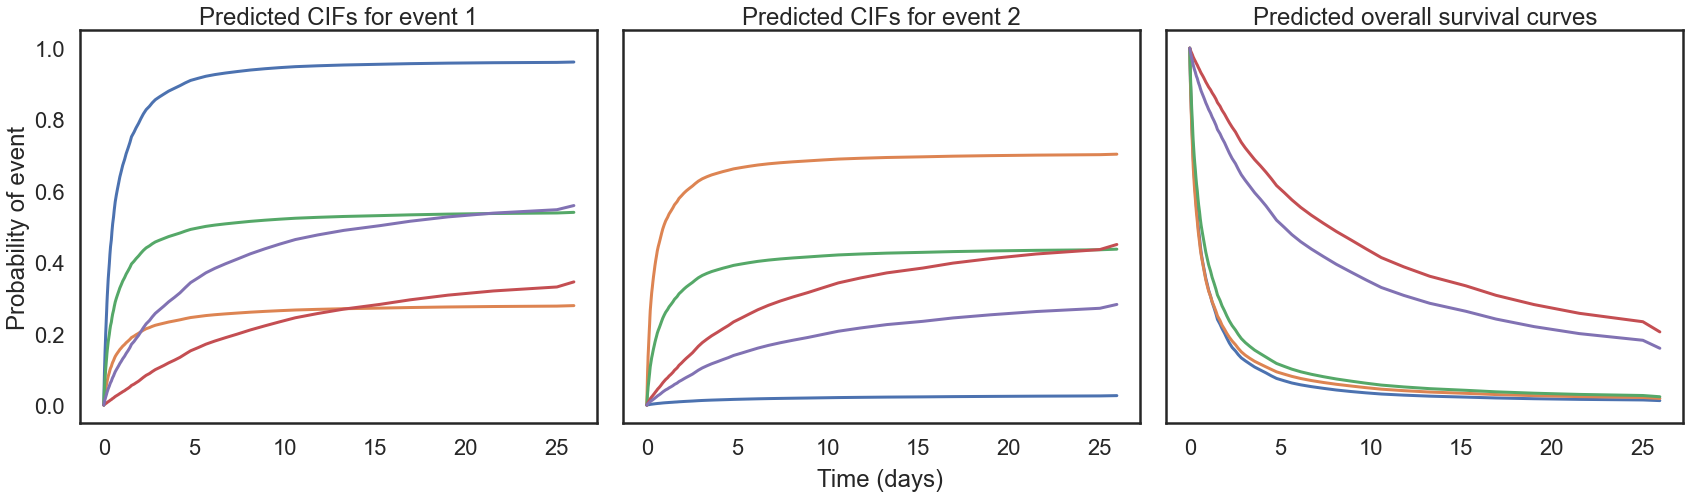

In [9]:
idxs = e1
colours = ["g", "r", "y"]

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24, 7))

for idx in idxs:
    ax[0].plot(np.pad(time_bins, (1, 0)), pred_cif[idx, 0, :])
    ax[1].plot(np.pad(time_bins, (1, 0)), pred_cif[idx, 1, :])
    ax[2].plot(np.pad(time_bins, (1, 0)), pred_survival[idx])
ax[0].set_ylabel("Probability of event")
ax[0].set_title("Predicted CIFs for event 1")
ax[1].set_title("Predicted CIFs for event 2")
ax[2].set_title("Predicted overall survival curves")
fig.text(0.52,0.01, "Time (days)", ha="center", va="center")
fig.tight_layout()

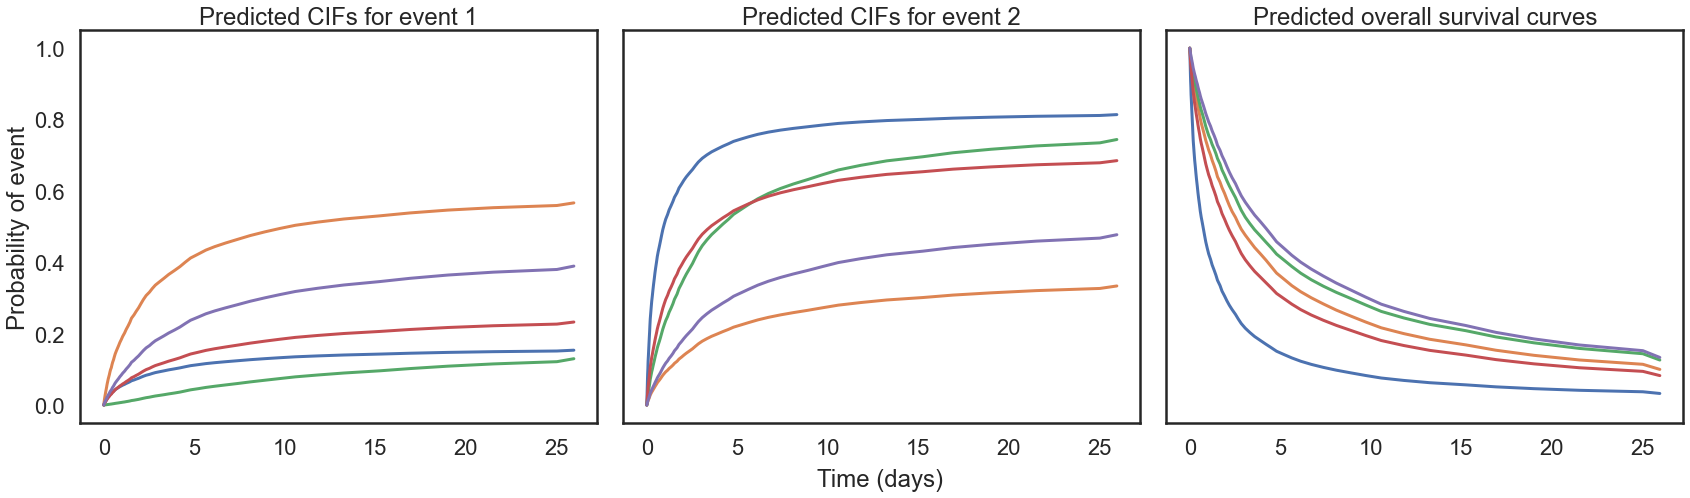

In [10]:
idxs = e2
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24, 7))

for idx in idxs:
    ax[0].plot(np.pad(time_bins, (1, 0)), pred_cif[idx, 0, :])
    ax[1].plot(np.pad(time_bins, (1, 0)), pred_cif[idx, 1, :])
    ax[2].plot(np.pad(time_bins, (1, 0)), pred_survival[idx])
ax[0].set_ylabel("Probability of event")
ax[0].set_title("Predicted CIFs for event 1")
ax[1].set_title("Predicted CIFs for event 2")
ax[2].set_title("Predicted overall survival curves")
fig.text(0.52,0.01, "Time (days)", ha="center", va="center")
fig.tight_layout()

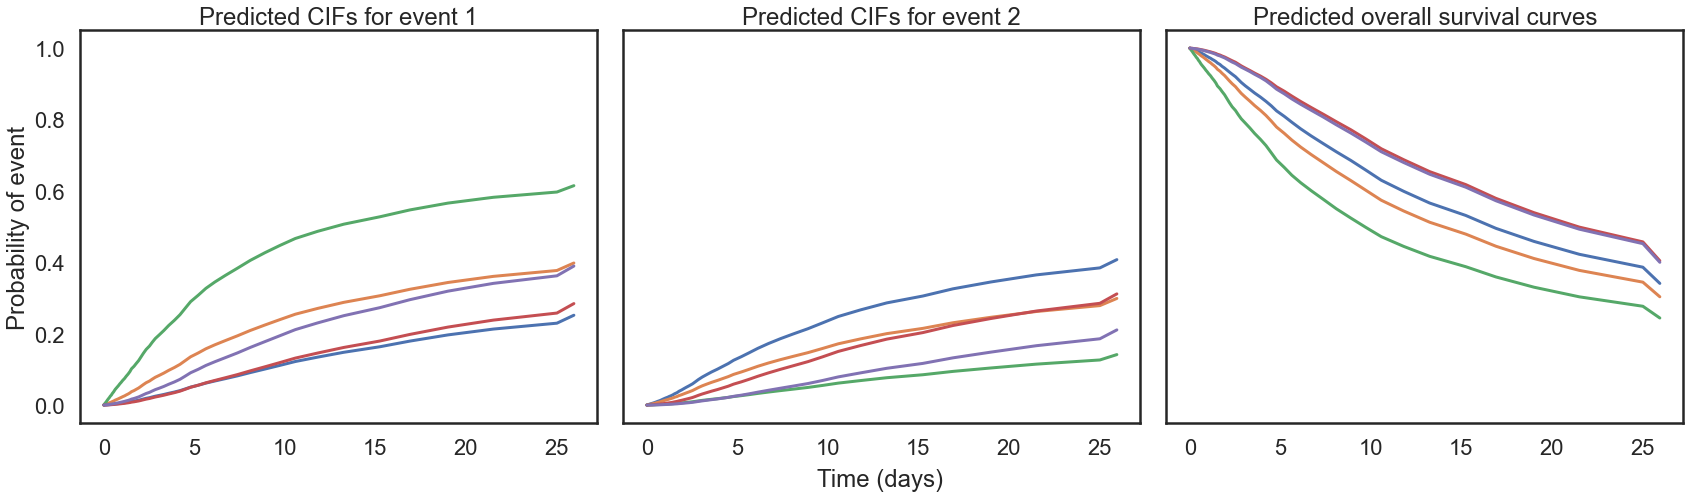

In [11]:
idxs = cens
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24, 7))

for idx in idxs:
    ax[0].plot(np.pad(time_bins, (1, 0)), pred_cif[idx, 0, :])
    ax[1].plot(np.pad(time_bins, (1, 0)), pred_cif[idx, 1, :])
    ax[2].plot(np.pad(time_bins, (1, 0)), pred_survival[idx])
ax[0].set_ylabel("Probability of event")
ax[0].set_title("Predicted CIFs for event 1")
ax[1].set_title("Predicted CIFs for event 2")
ax[2].set_title("Predicted overall survival curves")
fig.text(0.52,0.01, "Time (days)", ha="center", va="center")
fig.tight_layout()

Since the MTLR model associates a parameter with each time bin, we can plot the trained parameter values over time to see how the importance of each feature changes over time.

In [12]:
def plot_weights(weights, time_bins, feature_names, figsize=(10, 5)):
    """Plot MTLR model parameters over time."""
    num_events = weights.size(1) // len(time_bins)
    fig, ax = plt.subplots(1, num_events, figsize=figsize)
    weights = weights.view(weights.size(0), num_events, -1)
    for e, a in enumerate(ax):
        top_idxs = torch.argsort(weights[:, e, :].abs().sum(1), descending=True)[:5]
        for i in top_idxs:
            a.plot(np.pad(time_bins, (1, 0))[:-1], weights[i, e, :], label=feature_names[i])
        a.set_xlabel("Time (days)")
        a.set_ylabel("Weight")
        a.axhline(0, c="k", linestyle="--")
        a.legend()
    return ax

array([<AxesSubplot:xlabel='Time (days)', ylabel='Weight'>,
       <AxesSubplot:xlabel='Time (days)', ylabel='Weight'>], dtype=object)

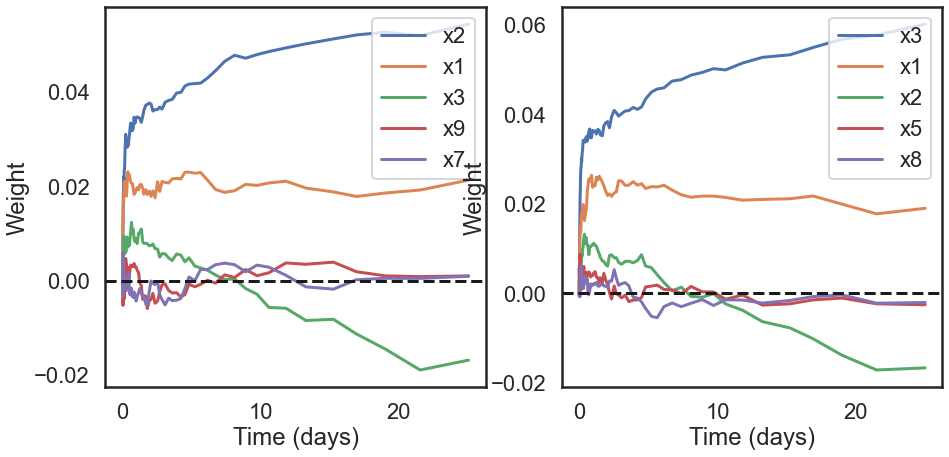

In [13]:
feature_names = data.drop(["time", "event"], axis=1).columns
plot_weights(mtlr.mtlr_weight.detach().cpu(), time_bins, feature_names, figsize=(15, 7))

## Nonlinear hazard and deep MTLR

In [14]:
data = make_synthetic_data(nonlinear=True) # hazard is quadratic in x_2/x_3
time_bins = make_time_bins(data["time"], event=data["event"])
y = encode_survival(data["time"], data["event"], time_bins)
censored = y.sum(dim=1) > 1

In [15]:
# prepare data
data_train, data_test = train_test_split(data, test_size=.25, random_state=42)
time_bins = make_time_bins(data_train["time"])
num_time_bins = len(time_bins) + 1

# fit MTLR model 
mtlr = MTLR(in_features=10, num_time_bins=num_time_bins, num_events=2)
mtlr = train_mtlr(mtlr, data_train, time_bins, num_epochs=100, 
                  lr=.005, batch_size=512, verbose=True, device=device)

with torch.no_grad():
    pred = mtlr(torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device))
    pred_risk = mtlr_risk(pred, 2).cpu().numpy()

ci_1 = concordance_index(data_test["time"], -pred_risk[:, 0], event_observed=data_test["event"] == 1)
ci_2 = concordance_index(data_test["time"], -pred_risk[:, 1], event_observed=data_test["event"] == 2)
print(f"CI for event 1 = {ci_1:.2f}")
print(f"CI for event 2 = {ci_2:.2f}")

[epoch  100/100]: 100%|██████████| 100/100 [00:07<00:00, 14.20it/s, loss = 4.8068]

CI for event 1 = 0.60
CI for event 2 = 0.60


The linear model doesn't do very well, since it cannot learn the quadratic relationship between features and hazard. Let's try using a multi-layer neural net.

In [16]:
# The MTLR module can be used just like any other PyTorch layer
mtlr = nn.Sequential(
    nn.Linear(10, 100),
    nn.ELU(),
    nn.Dropout(.4),
    nn.Linear(100, 32),
    nn.ELU(),
    nn.Dropout(.4),
    MTLR(in_features=32, num_time_bins=num_time_bins, num_events=2)
)

# mtlr = train_mtlr_cv(mtlr, data_train, time_bins, num_epochs=500, lr=.005,
#                      batch_size=512, cv=3, weight_decay=1e-5, verbose=True)
mtlr = train_mtlr(mtlr, data_train, time_bins, num_epochs=100, 
                  lr=.005, batch_size=512, verbose=True, device=device)
with torch.no_grad():
    pred = mtlr(torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device))
    pred_risk = mtlr_risk(pred, 2).cpu().numpy()

ci_1 = concordance_index(data_test["time"], -pred_risk[:, 0], event_observed=data_test["event"] == 1)
ci_2 = concordance_index(data_test["time"], -pred_risk[:, 1], event_observed=data_test["event"] == 2)
print(f"CI for event 1 = {ci_1:.2f}")
print(f"CI for event 2 = {ci_2:.2f}")

[epoch  100/100]: 100%|██████████| 100/100 [00:08<00:00, 11.67it/s, loss = 4.1123]


CI for event 1 = 0.89
CI for event 2 = 0.87


The neural net is able to successfully learn the nonlinear relationship, as expected.